# Atmosphere parameter testing!

Hypothesis: if we knew atmospheric parameters (Cn2, etc), we'd be able to predict the precise power spectrum of the atmosphere decently accurately.

Work from the 2019 Center for Adaptive Optics Fall Science Retreat, Keck Telemetry Hackathon.

## Steps

1. Check the coherence of the HCIPy-generated power spectra. That is, for fixed parameters, check that the power spectrum is the same/close enough to it over time.
2. Use HCIPy to generate the power spectrum for particular atmospheric parameters we know are on the Keck data.
3. Match to the true power spectrum from the Keck data.
4. Attempt to make a "truth power spectrum generator", i.e. a function that takes in known atmospheric parameters and returns a best guess of the power spectrum. 
5. Validate this on Keck data.
6. Make a big pile of linear algebra and work backwards to an empirical relationship between the truth power spectra and the optimal autoregressive model.

In [1]:
# utilities

import numpy as np
from scipy import signal
from matplotlib import pyplot as plt
from astropy.table import Table
from controller import Controller

f_sampling = 1000

rms = lambda data: np.sqrt(np.mean(data ** 2))
psd = lambda data: signal.periodogram(data, fs=f_sampling)

In [2]:
# step 1: coherence of HCIPy

from aberrations import *

heights = np.array([500, 1000, 2000, 4000, 8000, 16000])
velocities = np.array([10, 10, 10, 10, 10, 10])
Cn_squared = np.array([0.2283, 0.0883, 0.0666, 0.1458, 0.3350, 0.1350]) * 1e-12

make_atmosphere = make_custom_atmospheric_layers(heights, velocities, Cn_squared)
layers = make_atmosphere(pupil_grid, L0=10)

tt_cms_zeroed = make_atm_data(2000, layers=layers)[:,0]
tt_cms_shifted = make_atm_data(2000, layers=layers, zerotime=500)[:,0]

KeyboardInterrupt: 

In [ ]:
plt.loglog(*psd(tt_cms_zeroed), label='Unshifted')
plt.loglog(*psd(tt_cms_shifted), label='Shifted')
plt.ylim(1e-7)

Seems like HCIPy is decently coherent over time, but that could just be an oversimplification. Anyway, that's good enough to move on to step two!

In [3]:
# step 2: generate power spectra that we should see on the Keck data based on its atmospheric parameters.
# first, let's see what those atmospheric parameters even are.

from scipy import io
num = 128 # change this to 129-132 for others
filename = '../telemetry/n0' + str(num) + '_LGS_trs.sav'
telemetry = io.readsav(filename)
for key in telemetry.keys():
    try:
        print(key, telemetry[key].dtype)
    except AttributeError:
        print(key)

a (numpy.record, [(('conf_id', 'CONF_ID'), 'O'), (('timestamp', 'TIMESTAMP'), 'O'), (('subapintensity', 'SUBAPINTENSITY'), 'O'), (('offsetcentroid', 'OFFSETCENTROID'), 'O'), (('residualwavefront', 'RESIDUALWAVEFRONT'), 'O'), (('dmcommand', 'DMCOMMAND'), 'O'), (('dmcommandsclipped', 'DMCOMMANDSCLIPPED'), 'O'), (('residualrms', 'RESIDUALRMS'), 'O'), (('ttcommands', 'TTCOMMANDS'), 'O'), (('ttstraingauge', 'TTSTRAINGAUGE'), 'O'), (('ttcommandsclipped', 'TTCOMMANDSCLIPPED'), 'O')])
b (numpy.record, [(('conf_id', 'CONF_ID'), 'O'), (('timestamp', 'TIMESTAMP'), 'O'), (('apdcounts', 'APDCOUNTS'), 'O'), (('dttcentroids', 'DTTCENTROIDS'), 'O'), (('dttcommands', 'DTTCOMMANDS'), 'O'), (('dttstraingauge', 'DTTSTRAINGAUGE'), 'O'), (('dttcommandsclipped', 'DTTCOMMANDSCLIPPED'), 'O')])
uid >i4
cid >u4
nrec int32
rx >f4
cent_origin >f4
dm_origin >f4
dtt_offset >f4
tstamp_num >u8
tstamp_str_start
cent_g >f4
dm_servo >f4
dt_servo >f4
apd_imat >f4
apd_sky_back >f4
apd_threshold >f4
header object


In [9]:
telemetry.header

array([b'SIMPLE  =                    T / Tape is in Fits format                         ',
       b'BITPIX  =                   32 / Bits per pixel                                 ',
       b'NAXIS   =                    2 / Number of axes                                 ',
       b'NAXIS1  =                 1024 / Number of pixels in axis 1                     ',
       b'NAXIS2  =                 1024 / Number of pixels in axis 2                     ',
       b'BSCALE  =              1.00000 / Scaling factor                                 ',
       b'BZERO   =              0.00000 / Scaling zero-point                             ',
       b"OUTDIR  = '/sdata904/nirc15/2017may05/           ' / Original directory         ",
       b"ROOTNAME= 'n                 ' / File prefix                                    ",
       b'FRAMENO =                  128 / Frame number                                   ',
       b"FILENAME= 'n0128.fits        ' / Original File name                    

The parameters I want are in metadata_table.

In [11]:
metadata = Table.read('../telemetry/metadata_table.fits', format = 'fits')[597:602]
# indices 597-602 matches the data files we have

In [12]:
metadata

file,strehl,rms_err,fwhm,mjd,epoch,airmass,itime,coadds,band,az,dmgain,dtgain,wsfrrt,aolbfwhm,lsamppwr,lgrmswf,xref,yref,xstrehl,ystrehl,MASS,MASS_mjd,MASS_delta_t,DIMM,DIMM_mjd,DIMM_delta_t,MASSPRO_half,MASSPRO_1,MASSPRO_2,MASSPRO_4,MASSPRO_8,MASSPRO_16,MASSPRO,MASSPRO_mjd,MASSPRO_delta_t,wind_speed[kts],wind_speed,wind_direction,temperature,relative_humidity,pressure[mb],pressure,cfht_mjd,cfht_delta_t,telemetry_file
bytes10,float64,float64,float64,float64,bytes9,float64,float64,float64,bytes2,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes89
c0128.fits,0.166,453.5,88.55,57877.5454,17maylgs1,1.5188,2.8,10.0,Kp,176.24692,0.4,0.3,1000.0,1.107456,22.616039,276.3,456.687,718.555,557.573,429.809,0.13,57879.26006944444,-1.7146694444381865,0.4,57879.23924768518,-1.6938476851792075,1.59e-23,5.04e-22,2.7099999999999997e-20,5.2899999999999996e-15,2.06e-14,8.73e-15,0.17,57879.25578703704,-1.7103870370337972,23.0,11.832222212,40.0,0.8,35.0,618.1,0.6181,57877.54513888889,0.0002611111121950671,/u/steverobinson/data/keck_telemetry/20170504/sdata903/nirc15/2017may04/n0128_LGS_trs.sav
c0129.fits,0.185,438.9,84.44,57877.54599,17maylgs1,1.51843,2.8,10.0,Kp,176.49052,0.4,0.3,1000.0,1.179015,22.634359,289.1,456.869,718.827,558.109,429.939,0.13,57879.26006944444,-1.7140794444421772,0.4,57879.23924768518,-1.6932576851831982,1.59e-23,5.04e-22,2.7099999999999997e-20,5.2899999999999996e-15,2.06e-14,8.73e-15,0.17,57879.25578703704,-1.709797037037788,23.0,11.832222212,40.0,0.8,34.0,618.1,0.6181,57877.54583333333,0.0001566666687722318,/u/steverobinson/data/keck_telemetry/20170504/sdata903/nirc15/2017may04/n0129_LGS_trs.sav
c0130.fits,0.18100000000000002,441.8,84.08,57877.546579999995,17maylgs1,1.51808,2.8,10.0,Kp,176.73884,0.4,0.3,1000.0,1.106599,22.62978,304.1,457.041,719.189,558.372,430.272,0.13,57879.26006944444,-1.713489444446168,0.4,57879.23924768518,-1.692667685187189,1.59e-23,5.04e-22,2.7099999999999997e-20,5.2899999999999996e-15,2.06e-14,8.73e-15,0.17,57879.25578703704,-1.7092070370417787,22.0,11.317777768,36.0,0.81,36.0,618.1,0.6181,57877.54652777778,5.222221807343885e-05,/u/steverobinson/data/keck_telemetry/20170504/sdata903/nirc15/2017may04/n0130_LGS_trs.sav
c0131.fits,0.171,449.6,84.19,57877.547170000005,17maylgs1,1.51775,2.8,10.0,Kp,176.98601,0.4,0.3,1000.0,1.111239,22.597719,305.8,456.964,718.807,558.514,430.034,0.13,57879.26006944444,-1.7128994444356067,0.4,57879.23924768518,-1.6920776851766277,1.59e-23,5.04e-22,2.7099999999999997e-20,5.2899999999999996e-15,2.06e-14,8.73e-15,0.17,57879.25578703704,-1.7086170370312175,22.0,11.317777768,40.0,0.8,36.0,618.1,0.6181,57877.54722222222,-5.222221807343885e-05,/u/steverobinson/data/keck_telemetry/20170504/sdata903/nirc15/2017may04/n0131_LGS_trs.sav
c0132.fits,0.13699999999999998,476.3,95.7,57877.54821,17maylgs1,1.51728,2.8,10.0,Kp,177.42069,0.4,0.3,1000.0,1.111239,22.60688,305.8,421.838,697.679,523.389,408.728,0.13,57879.26006944444,-1.7118594444400514,0.4,57879.23924768518,-1.6910376851810724,1.59e-23,5.04e-22,2.7099999999999997e-20,5.2899999999999996e-15,2.06e-14,8.73e-15,0.17,57879.25578703704,-1.7075770370356622,21.0,10.803333324,38.0,0.8,36.0,618.1,0.6181,57877.54791666667,0.00029333333077374846,/u/steverobinson/data/keck_telemetry/20170504/sdata903/nirc15/2017may04/n0132_LGS_trs.sav


In [10]:
telemetry_table = Table.read('../telemetry/telemetry_table.fits', format = 'fits')[597:602]
telemetry_table

telemetry_file,residual_rms,residual_rms_std,dttcentroid_std,apdcounts_mean,apdcounts_std,subap_mean,subap_std
bytes78,float64,float64,float64,float64,float64,float64,float64
/g/lu/data/keck_telemetry/20170504/sdata903/nirc15/2017may04/n0128_LGS_trs.sav,36.90385818481445,9.493643760681152,0.062406933052660235,972.4280741367955,40.16505397825419,3621.889,115.31113
/g/lu/data/keck_telemetry/20170504/sdata903/nirc15/2017may04/n0129_LGS_trs.sav,62.02637100219727,33.23917007446289,0.062490288037778625,999.5443597704393,2292.5470959321487,3611.4036,106.15165
/g/lu/data/keck_telemetry/20170504/sdata903/nirc15/2017may04/n0130_LGS_trs.sav,95.57367706298828,21.239625930786133,0.06257208563516697,990.7202935365509,37.31915459037001,3595.5007,91.8607
/g/lu/data/keck_telemetry/20170504/sdata903/nirc15/2017may04/n0131_LGS_trs.sav,92.03258514404295,20.56272315979004,0.062121632756622025,993.9690469470318,39.82707094028541,3643.4119,101.64753
/g/lu/data/keck_telemetry/20170504/sdata903/nirc15/2017may04/n0132_LGS_trs.sav,89.28301239013672,19.10942840576172,0.06328529063564788,991.7745789820303,39.93879724971895,3647.084,123.36335


In [ ]:
# step 4, unvalidated

# scale_cn2 is the multiplying factor on HCIPy's default cn2
make_layers = lambda scale_cn2: make_custom_atmospheric_layers(heights, velocities, scale_cn2 * Cn_squared)(pupil_grid, L0=10)
# I also don't quite know what L0 is

def get_cn2tt(scale, steps=2000):
    layers = make_layers(scale)
    return make_atm_data(steps, layers=layers)[:,0] # please excuse all the overloading of names

def show_cn2tt(scale, steps=2000, hold=False):
    tt_cms = get_cn2tt(scale, steps)
    plt.loglog(*psd(tt_cms), label=str(scale))
    if not hold:
        plt.show()

In [ ]:
show_cn2tt(0.01,hold=True)
show_cn2tt(1,hold=True)
#show_cn2tt(100,hold=True)
plt.legend()
plt.ylim(1e-7)

In [5]:
tt_input = keck_pol[:2000,0]
stdint = Controller('stdint')
residuals, actions, pol = stdint.control(tt_input)

Starting at timestep 3


(1e-07, 0.03718386273845221)

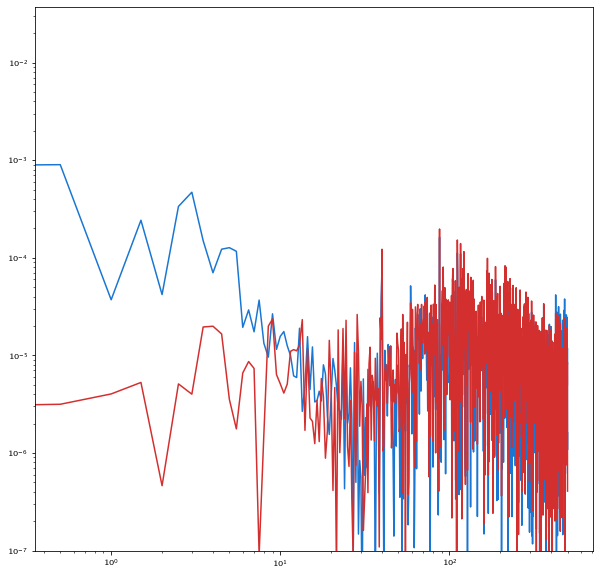

In [7]:
plt.figure(figsize=(10,10))
plt.loglog(*psd(tt_input))
plt.loglog(*psd(residuals))
plt.ylim(1e-7)

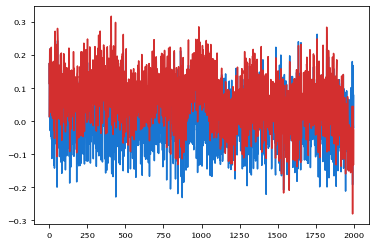

In [8]:
plt.plot(residuals)
plt.plot(tt_input)

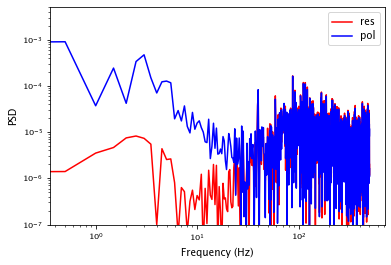

In [25]:
# that scale = 100 case looks a whole lot like a Keck data power spectrum. Including that weird high-freq peak.
# and the scale = 0.01 case looks a lot like what papers WANT a power spectrum to look like.
# let's formalize this.

from utils import *

keck_res, keck_com, keck_pol = get_keck_tts(130)
plt.loglog(*psd(keck_res[:2000, 0]), label='res', color='red')
plt.loglog(*psd(keck_pol[:2000, 0]), label='pol', color='blue')
#show_cn2tt(1000,hold=True)
plt.ylim(1e-7)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")
plt.legend()

(1e-07, 0.05132406896864022)

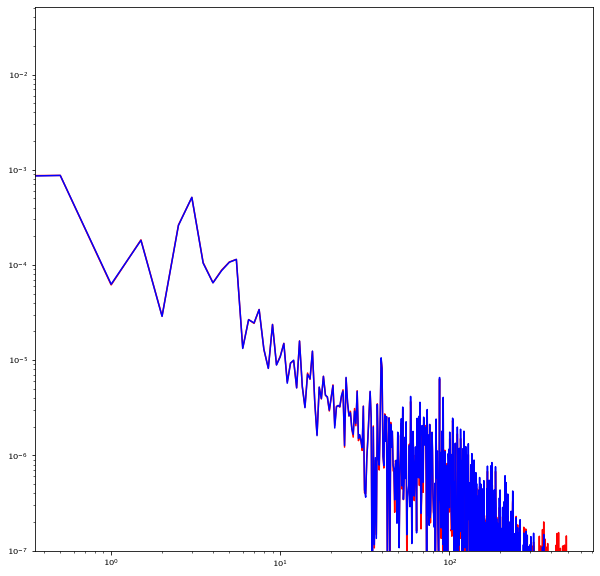

In [26]:
def make_impulse_response(overshoot, t_rise, T=np.arange(0, 1, 0.001)):
    # takes in fractional overshoot and rise time, returns a time-series impulse response satisfying it.
    # damping ratio from OS
    z = (-np.log(overshoot))/(np.sqrt(np.pi**2 + np.log(overshoot)**2))
    # find approximation to t_rise * natural frequency
    w = (1/t_rise) * (1.76 * z**3 - 0.417 * z**2 + 1.039 * z + 1)
    num = [w**2]
    den = [1, 2 * w * z, w**2]
    tf = signal.TransferFunction(num, den)
    impulse = signal.impulse(tf, T=T)
    return impulse

times, impulse = make_impulse_response(0.1, 1e-3)
keck_com_true = np.convolve(keck_com[:2000,0], impulse/sum(impulse))[:2000]

plt.figure(figsize=(10,10))
plt.loglog(*psd(keck_com[:2000, 0]), label='pol', color='red')
plt.loglog(*psd(keck_com_true), color='blue')
plt.ylim(1e-7)

/usr/local/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


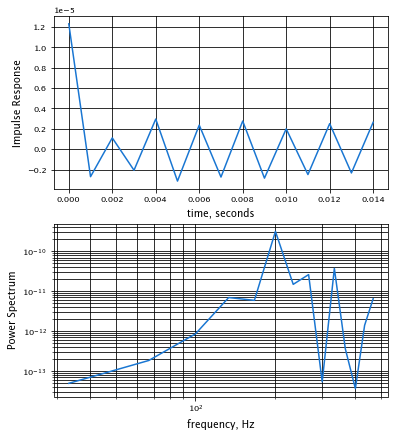

In [27]:
from fractal_deriv import *
a = design_filt(dt = 1e-3, tf = psd(keck_pol[:2000, 0] + np.random.normal(0, 0.06**2, (2000,)))[1], N=30)

/Users/adityasengupta/projects/adaptive-optics/control/dev/fractal_deriv.py:148: ComplexWarning: Casting complex values to real discards the imaginary part
  y[k] = np.sum(u[range(k,k-L,-1)]*a[0:L])


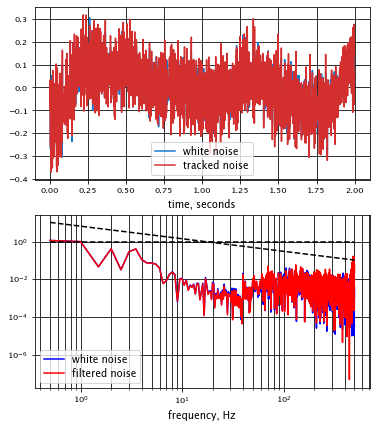

In [28]:
tracked = filt(a, dt=1e-3, u = keck_pol[2000:4000,0])

In [29]:
rms(tracked - keck_pol[2000:4000,0])

0.04684991686748291

In [30]:
psd_tofit = psd(keck_pol[:2000,0])[1]

In [31]:
plt.plot(samples)

NameError: name 'samples' is not defined